<a href="https://colab.research.google.com/github/DataJenius/NLPEncodingExperiment/blob/main/python/NLPEncodingExperiment_onehot300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#######################################################################################################
# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()

Finished!


In [ ]:
###########################################
# load all dependencies
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from stepbystep.v4 import StepByStep

from google.colab import files

In [ ]:
######################################################################################
# our labelled, one-hot encoded data is on github
# already broken into 5 validation groups for the sake of 5 models
# use 20% of data for val, 20% for test, and keep 60% for training
all_files = ['https://raw.githubusercontent.com/DataJenius/EmbeddingsDeepDive/main/data/v2/data_v2_comments_with_labels_onehot300_group1.csv',
             'https://raw.githubusercontent.com/DataJenius/EmbeddingsDeepDive/main/data/v2/data_v2_comments_with_labels_onehot300_group2.csv',
             'https://raw.githubusercontent.com/DataJenius/EmbeddingsDeepDive/main/data/v2/data_v2_comments_with_labels_onehot300_group3.csv',
             'https://raw.githubusercontent.com/DataJenius/EmbeddingsDeepDive/main/data/v2/data_v2_comments_with_labels_onehot300_group4.csv',
             'https://raw.githubusercontent.com/DataJenius/EmbeddingsDeepDive/main/data/v2/data_v2_comments_with_labels_onehot300_group5.csv']

# concat into a single dataframe and shuffle the contents
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_all_data   = pd.concat(df_from_each_file, ignore_index=True)
df_all_data = df_all_data.sample(frac=1).reset_index(drop=True)

# make sure we loaded what we think we did
print(df_all_data.head())
print(df_all_data.shape)

   msg_id  val_group  label  absolutely  action  actors  actual  adaptation  \
0   16194          4      0           0       1       0       0           0   
1    9034          3      0           0       0       0       0           0   
2   37106          3      1           0       0       0       0           0   
3   44159          2      1           0       0       0       0           0   
4   45675          5      1           0       0       1       0           0   

   age  ago  ...  wouldnt  wouldve  write  writers  writing  written  wrong  \
0    0    0  ...        0        0      0        0        0        0      0   
1    0    0  ...        0        0      0        0        0        0      0   
2    0    0  ...        0        0      0        0        0        0      0   
3    0    0  ...        0        0      0        0        0        0      0   
4    0    0  ...        0        0      0        0        0        0      0   

   wrote  yeah  youre  
0      0     0      1  
1 

In [ ]:
###############################################################################################
###############################################################################################
###############################################################################################
# All 5 experiments below will reuse everything above this line
###############################################################################################
###############################################################################################
###############################################################################################

In [ ]:
######################################################################################
# our data is already split into 5 validation groups, fully labelled
# change the `validation_test` below to re-train/test 5 times 
validation_group = 5 # set 1 to 5

# setup this experiment
test_input_method = 'one-hot (300)'
test_group = validation_group+1 
if test_group > 5: test_group = 1
print(test_input_method+" validation test #"+str(validation_group)+" using group #"+str(test_group)+" as holdout for testing")

# split into val/test/train based on validation group 
df_val = df_all_data.loc[df_all_data['val_group'] == validation_group]
df_test = df_all_data.loc[df_all_data['val_group'] == test_group]
df_train = df_all_data.loc[~df_all_data['val_group'].isin([validation_group,test_group])]
print("\n\nval - group ",df_val['val_group'].unique())
print(df_val.head())
print("\n\ntest - group ",df_test['val_group'].unique())
print(df_test.head())
print("\n\ntrain - group ",df_train['val_group'].unique())
print(df_train.head())

# extract our labels into tensors 
val_labels_tensor = torch.as_tensor(df_val['label'].to_numpy().reshape(-1, 1)).float()
test_labels_tensor = torch.as_tensor(df_test['label'].to_numpy().reshape(-1, 1)).float()
train_labels_tensor = torch.as_tensor(df_train['label'].to_numpy().reshape(-1, 1)).float()
print("\n\nLabel Tensors:")
print("val - ",val_labels_tensor.shape)
print("test - ",test_labels_tensor.shape)
print("train - ",train_labels_tensor.shape)

# extract our features into tensors 
df_val_features = df_val.loc[:, ~df_val.columns.isin(['msg_id', 'val_group', 'label'])]
val_features_tensor = torch.as_tensor(df_val_features.to_numpy()).float()
df_test_features = df_test.loc[:, ~df_test.columns.isin(['msg_id', 'val_group', 'label'])]
test_features_tensor = torch.as_tensor(df_test_features.to_numpy()).float()
df_train_features = df_train.loc[:, ~df_train.columns.isin(['msg_id', 'val_group', 'label'])]
train_features_tensor = torch.as_tensor(df_train_features.to_numpy()).float()
print("\n\nFeature Tensors:")
print("val - ",val_features_tensor.shape)
print("test - ",test_features_tensor.shape)
print("train - ",train_features_tensor.shape)

one-hot (300) validation test #5 using group #1 as holdout for testing


val - group  [5]
    msg_id  val_group  label  absolutely  action  actors  actual  adaptation  \
4    45675          5      1           0       0       1       0           0   
5    13199          5      0           0       1       0       0           0   
13   44575          5      1           0       0       0       0           0   
20    4877          5      0           0       0       0       0           0   
28   26494          5      1           0       0       0       1           0   

    age  ago  ...  wouldnt  wouldve  write  writers  writing  written  wrong  \
4     0    0  ...        0        0      0        0        0        0      0   
5     0    0  ...        0        0      0        0        1        0      0   
13    0    0  ...        0        0      0        0        0        0      0   
20    0    0  ...        0        0      0        0        0        0      0   
28    0    0  ...        0   

In [ ]:
######################################################################################
# build a TensorDataset containing ALL data points for train/val
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)

# build a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)
print(train_loader)
print(val_loader)

In [ ]:
###############################################################################################
# use same model structure, just change embeddings into this one-hot input instead
torch.manual_seed(101)

# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/ 
model = nn.Sequential(
    nn.Linear(300, 1) 
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# get details about the model
def count_all_parameters(model):
    return sum(p.numel() for p in model.parameters())
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_all_parameters(model)
num_params_train = count_trainable_parameters(model)
print(model)
print(num_params, "total params")
print(num_params_train, "trainable params")

Sequential(
  (0): Linear(in_features=300, out_features=1, bias=True)
)
301 total params
301 trainable params


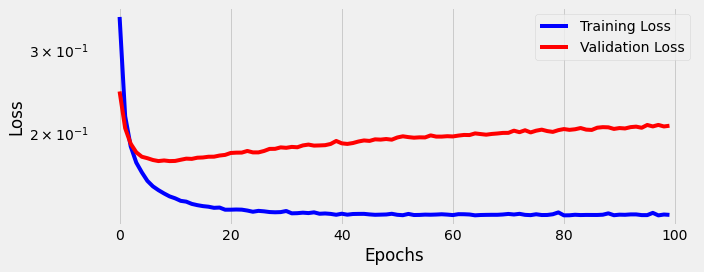

In [ ]:
###############################################################################################
# train the model - only takes about 10s for 20 epochs, 1m for 100 epochs
sbs_oh = StepByStep(model, loss_fn, optimizer)
sbs_oh.set_loaders(train_loader, val_loader)
sbs_oh.train(100)

# plot loss over epochs
fig = sbs_oh.plot_losses()

In [ ]:
##############################################################
# how well does this model do with data it has never seen?
sbs_oh.model.eval()
out = sbs_oh.model(test_features_tensor)

# record detailed predictions for this model
df_experiment_results = pd.DataFrame({'method': test_input_method,
                                      'params': num_params,
                                      'params_train': num_params_train, 
                                      'val_group': validation_group,
                                      'test_group': test_group,                                      
                                      'p_token_coverage': 0,
                                      'msg_id': df_test['msg_id'],
                                      'label': df_test['label'],
                                      'p_sigmoid': torch.sigmoid(out).squeeze().tolist()}) 
df_experiment_results['pred'] = np.where(df_experiment_results['p_sigmoid']>0.5, 1, 0)
df_experiment_results['correct'] = np.where(df_experiment_results['pred']==df_experiment_results['label'], 1, 0)
df_experiment_results['tp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==1), 1, 0)
df_experiment_results['fp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['tn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['fn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==1), 1, 0)

# calculate metrics
tp = df_experiment_results["tp"].sum()
fp = df_experiment_results["fp"].sum()
tn = df_experiment_results["tn"].sum()
fn = df_experiment_results["fn"].sum()
prec = tp/(tp+fp)
recall = tp/(tp+fn)

# show our metrics
print("ACC: ",df_experiment_results["correct"].mean())
print("Precision: ",prec)
print("Recall: ", recall)

# save results to local CSV
file_name = 'results_'+test_input_method+'_test_'+str(validation_group)+'.csv'
df_experiment_results.to_csv(file_name, index=False) 
files.download(file_name)
print("\n\n",df_experiment_results.head(10))

ACC:  0.918
Precision:  0.9138613861386139
Recall:  0.923


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



            method  params  params_train  val_group  test_group  \
12  one-hot (300)     301           301          5           1   
14  one-hot (300)     301           301          5           1   
23  one-hot (300)     301           301          5           1   
25  one-hot (300)     301           301          5           1   
30  one-hot (300)     301           301          5           1   
35  one-hot (300)     301           301          5           1   
37  one-hot (300)     301           301          5           1   
41  one-hot (300)     301           301          5           1   
50  one-hot (300)     301           301          5           1   
55  one-hot (300)     301           301          5           1   

    p_token_coverage  msg_id  label     p_sigmoid  pred  correct  tp  fp  tn  \
12                 0   48884      1  4.537869e-01     0        0   0   0   0   
14                 0   31742      1  9.662976e-01     1        1   1   0   0   
23                 0     924  